In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np 
device = tf.device("gpu:0")
# Step 1: Dataset Preparation
# Set the paths to your dataset
train_data_dir =   './Train/'
test_data_dir =   'Val/'
 

In [2]:

# Step 2: Data Preprocessing
image_size = (224, 224)  # Adjust the size as per your requirements

# Data augmentation for training set (optional)

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=10,  # Example of augmentation parameters
    zoom_range=0.1,
    horizontal_flip=True
)


# Data normalization for testing set
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical'
)



Found 5573 images belonging to 3 classes.
Found 1541 images belonging to 3 classes.


In [3]:

# Step 5: Check the class labels
class_labels = list(train_generator.class_indices.keys())
num_classes = len(class_labels)

# Step 6: Check the class imbalance
class_counts = np.sum(train_generator.labels, axis=0)

# Step 7: Print dataset statistics
print("Number of classes:", num_classes)
print("Class labels:", class_labels)
print("Class counts:", class_counts)


Number of classes: 3
Class labels: ['Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'nonValid']
Class counts: 5332


In [4]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.layers import Dropout
l1_weight = 0.001  # L1 regularization weight
l2_weight = 0.001  # L2 regularization weight
dropout_rate = 0.5  # Dropout rate


# Step 3: Model Creation and Fine-tuning
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224,224, 3))


In [5]:

for layer in base_model.layers:  # Fine-tune the last n layers
    layer.trainable = False

x = base_model.output

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Add more convolutional layers if desired
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(l1_weight, l2_weight))(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)

x = Dropout(dropout_rate)(x)  # Adding a Dropout layer with the specified dropout rate
predictions = layers.Dense(3, activation='softmax')(x)



In [6]:
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [7]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
# ...

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)
checkpoint = ModelCheckpoint('PepperModel.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)


In [8]:
with tf.device("/GPU:0"):
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        steps_per_epoch=train_generator.n // train_generator.batch_size,
        validation_steps=validation_generator.n // validation_generator.batch_size,
        epochs=20,
        callbacks=[reduce_lr, checkpoint, early_stop]
    )



Epoch 1/20
174/174 [==============================] - 646s 4s/step - loss: 1.9386 - accuracy: 0.6493 - val_loss: 0.9497 - val_accuracy: 0.8678

Epoch 00001: val_accuracy improved from -inf to 0.86784, saving model to STRAWBERRYBESTMODEL.h5
Epoch 2/20
174/174 [==============================] - 627s 4s/step - loss: 0.7478 - accuracy: 0.8731 - val_loss: 0.5681 - val_accuracy: 0.8626

Epoch 00002: val_accuracy did not improve from 0.86784
Epoch 3/20
174/174 [==============================] - 624s 4s/step - loss: 0.4555 - accuracy: 0.9049 - val_loss: 0.3201 - val_accuracy: 0.9303

Epoch 00003: val_accuracy improved from 0.86784 to 0.93034, saving model to STRAWBERRYBESTMODEL.h5
Epoch 4/20
174/174 [==============================] - 462s 3s/step - loss: 0.3303 - accuracy: 0.9235 - val_loss: 0.2972 - val_accuracy: 0.9264

Epoch 00004: val_accuracy did not improve from 0.93034
Epoch 5/20
174/174 [==============================] - 653s 4s/step - loss: 0.2777 - accuracy: 0.9368 - val_loss: 0.2197

In [9]:

# Step 5: Model Evaluation
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation loss: {loss}")
print(f"Validation accuracy: {accuracy}")

49/49 [==============================] - 38s 779ms/step - loss: 0.1302 - accuracy: 0.9676
Validation loss: 0.1302219182252884
Validation accuracy: 0.9675535559654236


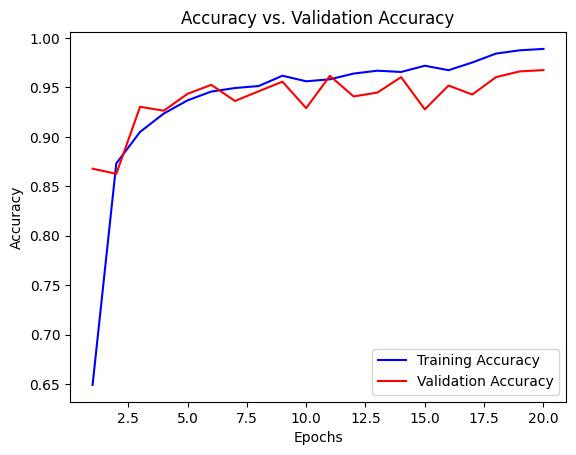

In [10]:
import matplotlib.pyplot as plt

accuracy=[0.6493,0.8731,0.9049,0.9235,0.9368,0.9457,0.9493,0.9513,0.9617,0.9561,0.9581,0.9639,0.9668,0.9655,0.9718,0.9673,0.9751,0.9841,0.9874,0.9888]
val_accuracy=[0.8678,0.8626,0.9303,0.9264,0.9434,0.9525,0.9362,0.9460,0.9557,0.9290,0.9616,0.9408,0.9447,0.9603,0.9277,0.9518,0.9427,0.9603,0.9661,0.9674]

# Plotting the graph
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Accuracy vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

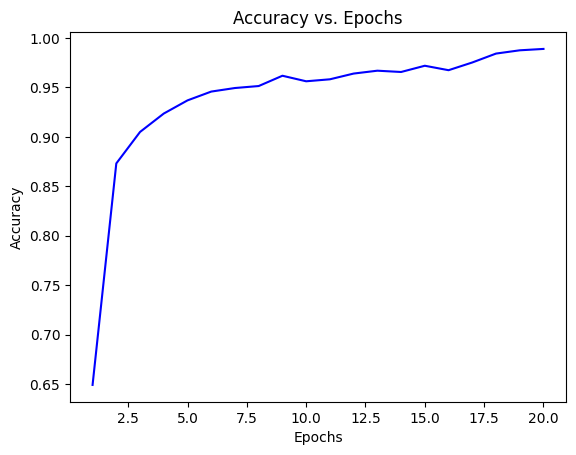

In [11]:
import matplotlib.pyplot as plt

epochs = range(1, len(accuracy) + 1)

# Plotting the graph
plt.plot(epochs, accuracy, 'b')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


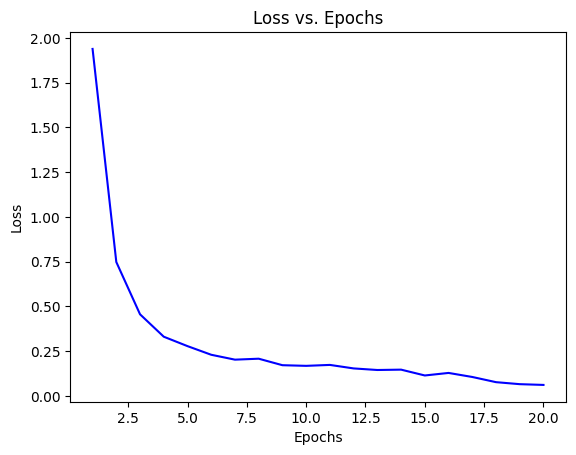

In [12]:
loss=[1.9386,0.7478,0.4555,0.3303,0.2777,0.2294,0.2021,0.2074,0.1711,0.1675,0.1727,0.1531,0.1443,0.1463,0.1137,0.1279,0.1053,0.0763,0.0651,0.0609]
val_loss=[0.9497,0.5681,0.3201,0.2972,0.2197,0.1889,0.2529,0.2031,0.1733,0.2351,0.1627,0.2388,0.2167,0.1534,0.2828,0.1757,0.1925,0.1443,0.1317,0.1306]

# Plotting the graph
plt.plot(epochs, loss, 'b')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [12]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('PepperModel.h5')


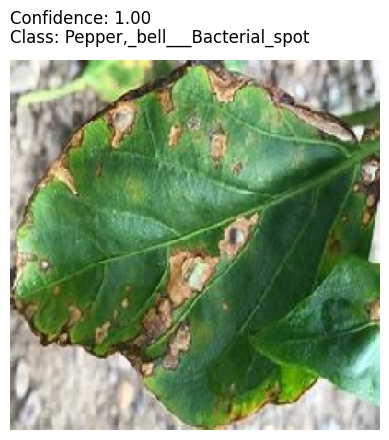

In [13]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np


# Load and preprocess the image
img_path = "PathImage"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # Normalize the image pixel values
input_img = np.expand_dims(img_array, axis=0)

# Perform predictions on the image
predictions = model.predict(input_img)
class_names = list(train_generator.class_indices.keys())

# Get the index and confidence of the maximum confidence prediction
max_index = np.argmax(predictions[0])
max_confidence = predictions[0][max_index]
max_class_name = class_names[max_index]

# Plot the image
fig, ax = plt.subplots()
ax.imshow(img)
ax.axis('off')

# Print the class and confidence below the image
ax.text(0, 1.05, f"Class: {max_class_name}", transform=ax.transAxes, fontsize=12)
ax.text(0, 1.1, f"Confidence: {max_confidence:.2f}", transform=ax.transAxes, fontsize=12)

plt.show()
